In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare
import seaborn as sns

In [2]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [4]:
df = prepare.prep_data(df)

In [5]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [6]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [7]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [8]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(df, on ='zip_code')

In [9]:
new_df.to_csv('Geo_Crime_Reports.csv')

In [10]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 349574 entries, 0 to 349573
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          349574 non-null  object        
 1   geometry          349574 non-null  geometry      
 2   crime_type        349574 non-null  object        
 3   family_violence   349574 non-null  object        
 4   occurrence_time   349574 non-null  datetime64[ns]
 5   occurrence_date   349574 non-null  datetime64[ns]
 6   report_time       349574 non-null  datetime64[ns]
 7   report_date       349574 non-null  datetime64[ns]
 8   location_type     349574 non-null  object        
 9   address           349574 non-null  object        
 10  council_district  349574 non-null  object        
 11  sector            349574 non-null  object        
 12  district          349574 non-null  object        
 13  latitude          349574 non-null  float64       
 

In [11]:
new_df.head()

,zip_code,geometry,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared
0,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF VEHICLE,N,2021-12-31 22:28:00,2021-12-31,2021-12-31 22:28:00,2021-12-31,PARKING /DROP LOT/ GARAGE,901 LITTLE TEXAS LN,2,FR,4,30.198187,-97.769155,not cleared,2022-01-03,False
1,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",ASSAULT BY CONTACT FAM/DATING,Y,2021-12-31 18:56:00,2021-12-31,2021-12-31 18:56:00,2021-12-31,RESIDENCE / HOME,4320 S CONGRESS AVE,3,DA,3,30.219033,-97.767189,not cleared,2022-01-03,False
2,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT,N,2021-12-31 18:00:00,2021-12-31,2022-01-10 14:57:00,2022-01-10,COMMERCIAL / OFFICE BUILDING,4501 TERRY O LN,3,DA,3,30.213162,-97.760094,not cleared,2022-01-12,False
3,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF VEH-NO SUSPECT/FU,N,2021-12-31 18:00:00,2021-12-31,2022-01-07 10:19:00,2022-01-07,RESIDENCE / HOME,7001 COOPER LN,2,FR,3,30.195661,-97.792699,not cleared,2022-01-10,False
4,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",FAMILY DISTURBANCE,N,2021-12-31 15:55:00,2021-12-31,2021-12-31 16:33:00,2021-12-31,OTHER / UNKNOWN,E WILLIAM CANNON DR / S CONGRESS AVE,2,FR,3,30.193012,-97.778879,not cleared,2022-01-26,False


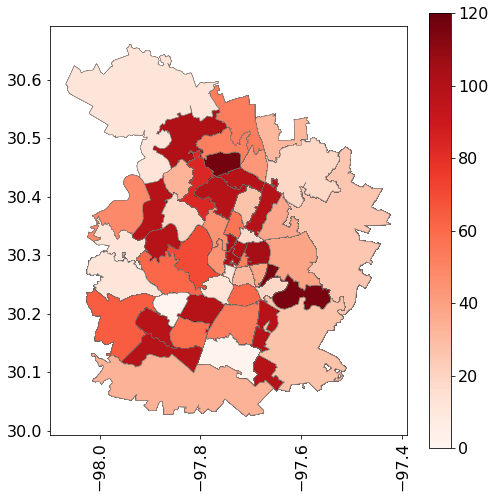

In [12]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [13]:
train, validate, test = prepare.split_data(new_df)

In [14]:
train2 = train.copy()

In [15]:
#df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
train2 = train2.set_index('occurrence_date').sort_index()

In [17]:
#Split by month first
train2['month'] = train2.index.month_name()
train2['weekdays'] = train2.index.day_name()
train2['year'] = train2.index.year

In [ ]:
#train2.groupby(train2.occurrence_date.dt.month).crime_type.count().idxmax()

In [45]:
y = train2.groupby(['weekdays','year'])['crime_type'].count()

In [50]:
y

weekdays   year
Monday     2018    7265
           2019    7506
           2020    7165
           2021    6387
Tuesday    2018    6841
           2019    7466
           2020    7082
           2021    5947
Wednesday  2018    7002
           2019    7100
           2020    7380
           2021    5954
Thursday   2018    7117
           2019    7021
           2020    7178
           2021    5973
Friday     2018    7708
           2019    8083
           2020    7479
           2021    6680
Saturday   2018    7412
           2019    7485
           2020    6851
           2021    6098
Sunday     2018    7070
           2019    7548
           2020    6829
           2021    6134
Name: crime_type, dtype: int64

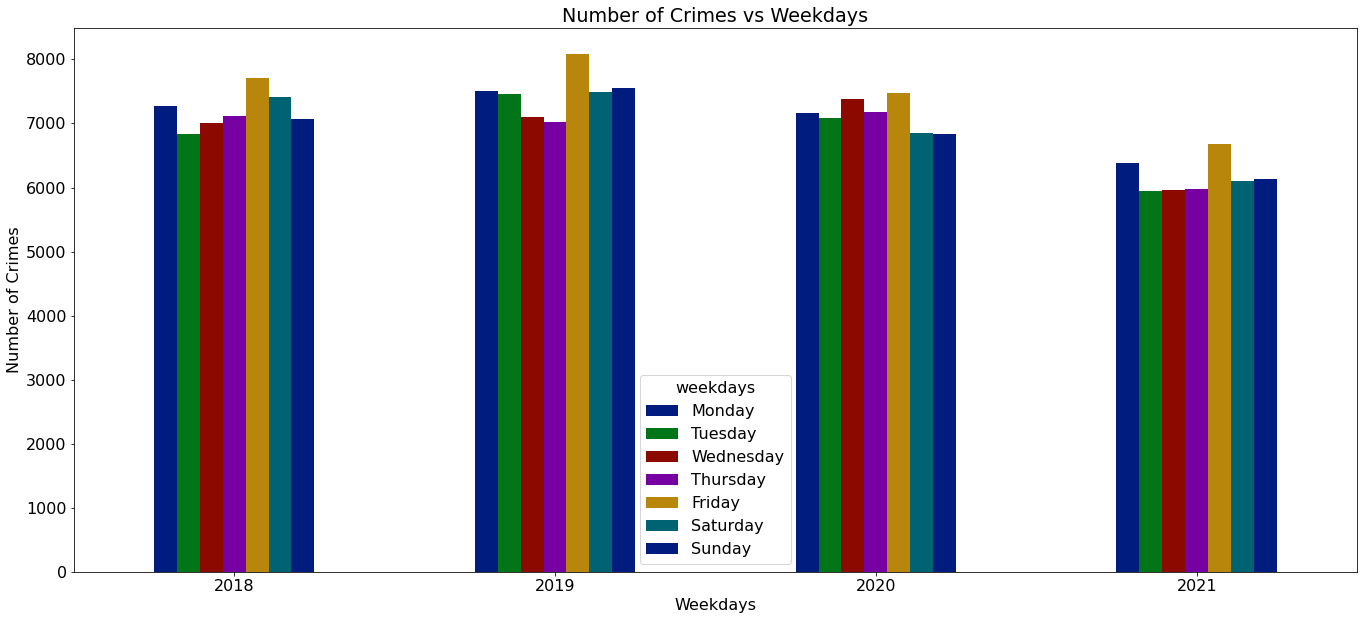

In [60]:
#Take a look at all the crime types
train2['weekdays'] = pd.Categorical(train2['weekdays'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#overall_mean = df.groupby('month').crime_type.value_counts()
#Assuming 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 =Saturday
y.unstack(0).plot.bar()
#sns.barplot(x=None, y = y, data = y, ci = None)
plt.title("Number of Crimes vs Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [61]:
#Do 1 sample t-test compare friday vs the rest

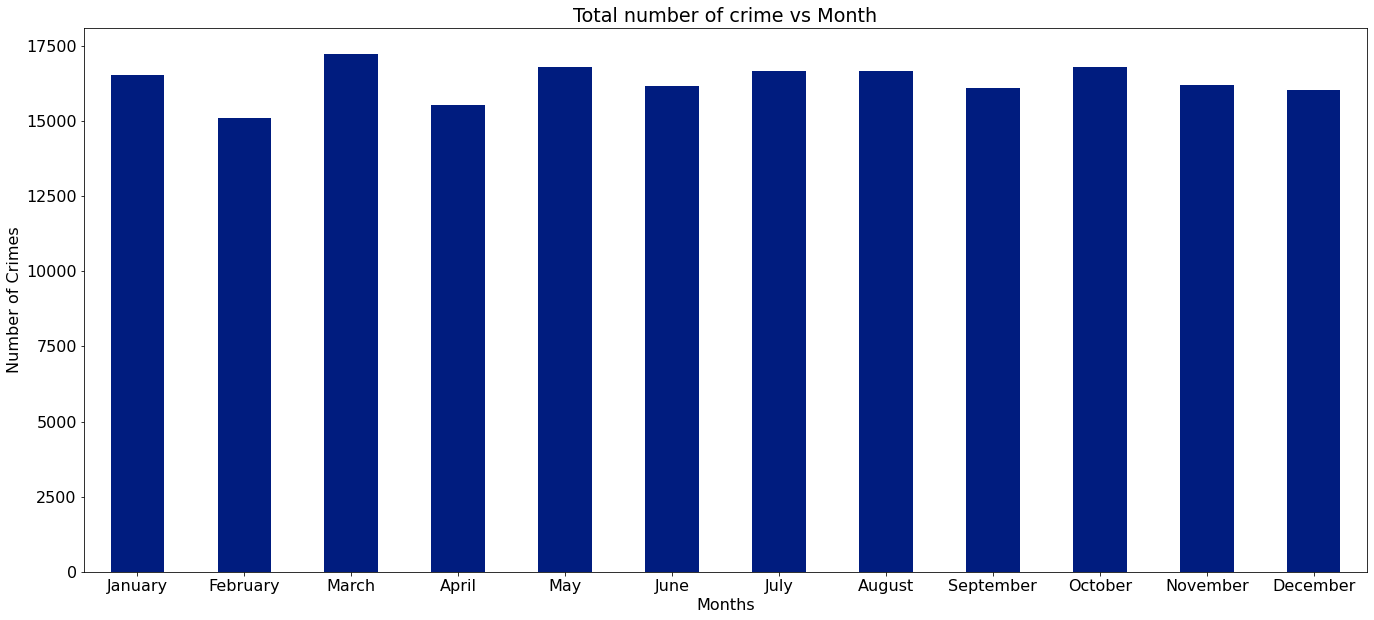

In [28]:
#Take a look at all the crime types
train2['month'] = pd.Categorical(train2['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
train2.groupby('month').crime_type.count().plot.bar()
plt.title("Total number of crime vs Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

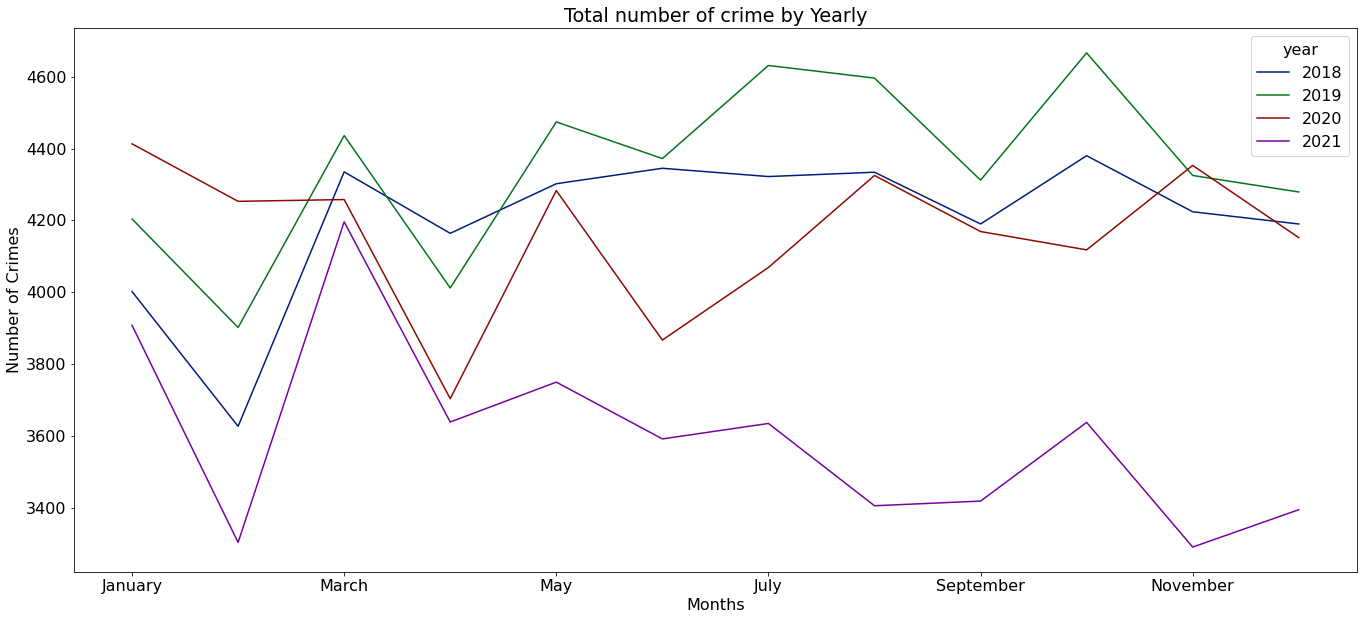

In [30]:
train2.groupby(['year', 'month']).crime_type.count().unstack(0).plot.line()
plt.title("Total number of crime by Yearly")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

#### Take away 
- From the visuals, we can see that Friday (2019) has higest, all the months have almost the same number of crime and year of 2019. But still need to take a look deeper into which weekday of the year has the higest number.